In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import requests
import datetime
import pycountry as pc
import math

# countries_list = ["DK"]
countries_list = ["AT", "BE", "BG", "CH", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "HU", "IT", "IS", "LT", "LV", "LU", "NL", "NO", "PL", "PT", "SE", "SK", "UK"]
a3_countries_list = []
for country in countries_list[:-1]:
    #print(country)
    a3_countries_list.append(pc.countries.get(alpha_2=country).alpha_3)
# a3_countries_list.append("GBR")
#print(a3_countries_list)
download_data = False
# folder_eu = "https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/true/"
# file_eu = "csv/DEMO_R_MWK_TS$DEFAULTVIEW"
# file_eu = "csv/DEMO_MMONTH__custom_26121"
# file_eu = "csv/DEMO_R_MWK_TS__custom_26098"

# folder_uk = "https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/"

# weeknr = datetime.date(2010, 6, 16).isocalendar()[1]
# filelist_uk = []
# for year in range(2010, 2021):
#     if year >= 2020:
#         filelist_uk.append("{0}/publishedweek{1}{0}.xlsx".format(year, 38))
#     if 2019 >= year > 2016:
#         filelist_uk.append("{0}/publishedweek52{0}.xls".format(year))
#     if 2016 >= year:
#         filelist_uk.append("{0}/publishedweek{0}.xls".format(year))

# filelist_uk = ["2020/publishedweek382020.xlsx", "2019/publishedweek522020.xls", 
#                 "2018/publishedweek522020.xls", "2017/publishedweek522020.xls", 
#                 "2016/publishedweek522020.xls", "2015/publishedweek2020.xls", 
#                 "2014/publishedweek2014.xls", "2013/publishedweek2020.xls", 
#                 "2012/publishedweek2012.xls", "2011/publishedweek2020.xls"]


# file_uk = "2020/publishedweek382020.xlsx"

# filelist_uk

# if download_data:
#     requests.get(url).content


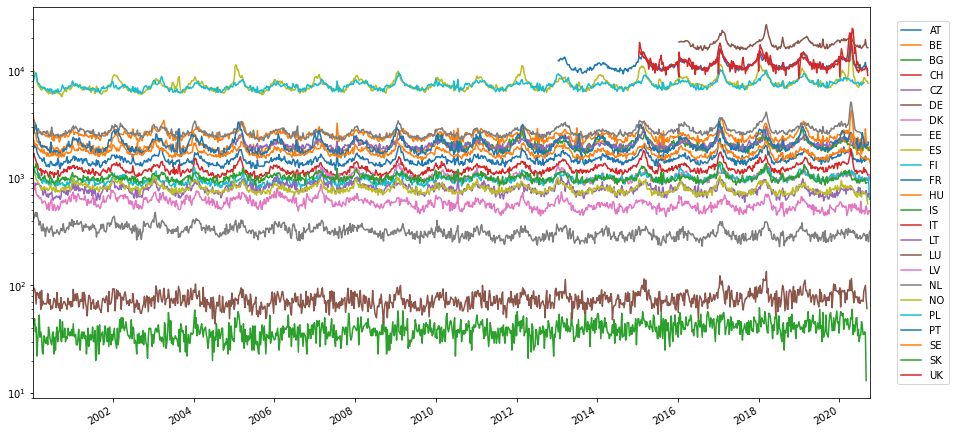

In [2]:
folder_eu_weekly = "https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/true/"
# file_eu_weekly = "csv/DEMO_R_MWK_TS$DEFAULTVIEW"
# file_eu_weekly = "csv/DEMO_MMONTH__custom_26121"
# file_eu_weekly = "csv/DEMO_R_MWK_10__custom_32605"
file_eu_weekly = "csv/DEMO_R_MWK_TS__custom_26098"
eu_weekly_df = pd.read_csv(folder_eu_weekly + file_eu_weekly, sep='[",",";"]', engine="python", parse_dates=True)
eu_weekly_df.rename(columns = {'geo\TIME_PERIOD':'geo'}, inplace=True)
eu_weekly_df.replace(r':', np.NaN, regex=True, inplace=True)
# eu_weekly_df.fillna(0, inplace = True)
eu_weekly_df.replace([r'p$', r'e$'], [r'']*2, regex=True, inplace=True)
# eu_weekly_df.replace([r'e$'], [r''], regex=True, inplace=True)
eu_weekly_df = eu_weekly_df[(eu_weekly_df["sex"]=="T") & (eu_weekly_df["geo"].isin(countries_list))]
w99_list = ["{}-W99 ".format(i) for i in range(2000, 2019)]
eu_weekly_df.drop(columns=["freq", "unit", "sex"] + w99_list, inplace=True)

eu_weekly_df = eu_weekly_df.T
eu_weekly_df.columns = eu_weekly_df.loc["geo"]
eu_weekly_df.drop(["geo"], inplace=True)
eu_weekly_df = eu_weekly_df.apply(pd.to_numeric)
ri = [i.rstrip() + "-0" for i in eu_weekly_df.index]
eu_weekly_df.index = pd.to_datetime(ri, format="%Y-W%W-%w")
eu_weekly_df.loc[:].plot(figsize=(15,8))
scale = "log"
plt.yscale(scale)
plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))
plt.savefig("mortality_{}.pdf".format(scale))


/usr/lib/python3/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3/dist-packages/pandas/core/generic.py:9062: ComplexWarning: Casting complex values to real discards the imaginary part
  new_other[icond] = other
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/u

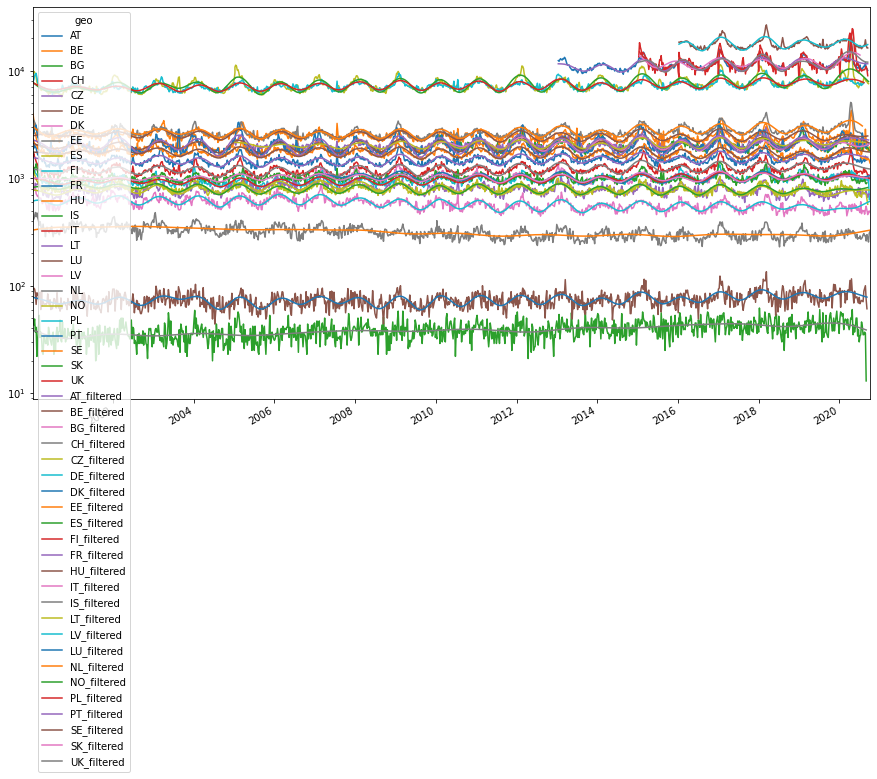

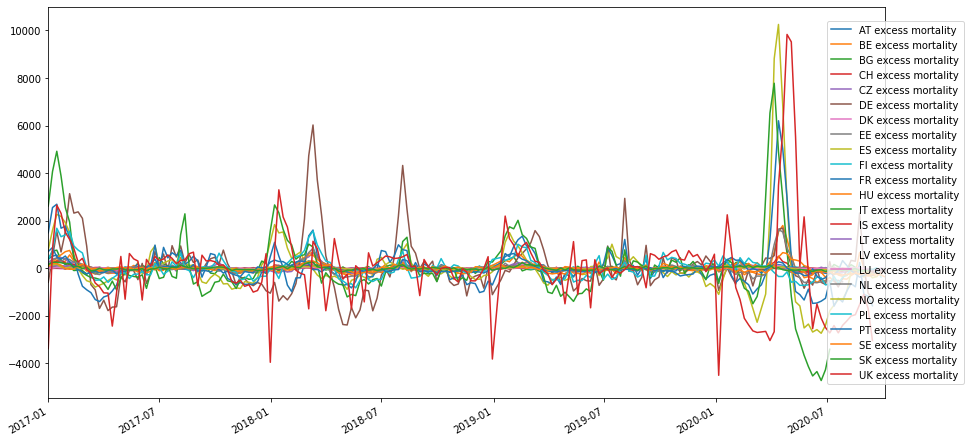

In [3]:
# def true_range(mask):
#     ret_list = []
#     for i in range(len(mask)):
#         if mask[i]:
#             ret_list.append(i)
#             break
#     for i in range(len(mask)):
#         if mask[-1-i]:
#             ret_list.append(len(mask) - i)
#             break
#     return ret_list

# test_list = [False]*3 + [True]*2 + [False] + [True]*2 + [False]*2
# print(test_list)
# print(true_range(test_list))  

spectral_analysis = True
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

if spectral_analysis:
    eu_weekly_filtered_df = eu_weekly_df
    spec_list = []
    freq_list = []
    for country in countries_list:
        mask = np.isfinite(eu_weekly_df[country])

        spec = np.fft.fft(eu_weekly_df[country][mask])
        t = np.arange(len(eu_weekly_df[country][mask]))
        freq = np.fft.fftfreq(t.shape[-1])
        power = np.abs(spec)**2
        
        # Find Peak
        pos_mask = np.where(freq > 0)
        freq_masked = freq[pos_mask]
        peak_freq = freq_masked[power[pos_mask].argmax()]
        
        # Filter
        precision = 2
        low_pass_filter = round_up(peak_freq, precision) # + 1*10**(-precision)
        filter_spec = spec.copy()
        filter_spec[np.abs(freq) > low_pass_filter] = 0
        filtered_sig = np.fft.ifft(filter_spec)
        
        eu_weekly_df[country+"_filtered"] = eu_weekly_df[country]
        eu_weekly_df[country+"_filtered"][mask] = filtered_sig
        #eu_weekly_filtered_df[country][mask] = filtered_sig
        
        # spec_list.append(spec)
        # freq_list.append(freq)
        # power_list.append(power)
        # filter_spec_list.append(spec)
        
        # eu_weekly_df[country].sub(eu_weekly_df[country + "_filtered"], axis=0).plot(figsize=(15,8))
eu_weekly_df.plot(figsize=(15,8))
scale = "log"
plt.yscale(scale)
plt.savefig("mortality_and_fourier_{}".format(scale))
fig, ax = plt.subplots()
view_start = "2017-01"
for country in countries_list:
    eu_weekly_df[country].loc[view_start:].sub(eu_weekly_df[country + "_filtered"].loc[view_start:], axis=0).plot(figsize=(15,8), ax=ax, label="{} excess mortality".format(country))

# plt.yscale("log")
plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))
plt.savefig("figs/excess_mortality_fourier.pdf")

# plt.figure(figsize=(15,8))
# plt.axvline(low_pass_filter)
# plt.axvline(-low_pass_filter)
# plt.plot(freq, spec.real, freq, spec.imag)#, freq, power)

#plt.yscale("log")
#plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))

In [4]:
folder_eu_daily = "https://opendata.ecdc.europa.eu/covid19/casedistribution/"
file_eu_daily = "csv"
date_parser_daily = lambda x: pd.datetime.strptime(str(x), "%d/%m/%Y")
eu_daily_df = pd.read_csv(folder_eu_daily + file_eu_daily, index_col="dateRep", parse_dates=["dateRep"], date_parser=date_parser_daily)
def moving_avg(data, avg_margin=3):
    return [0]*avg_margin + [sum(data[i-avg_margin:i+avg_margin+1])/(1+2*avg_margin) for i in range(avg_margin, len(data)-avg_margin)] + [0]*avg_margin
# eu_daily_df["deaths_smooth"] = moving_avg(eu_daily_df["deaths"])
# eu_daily_df

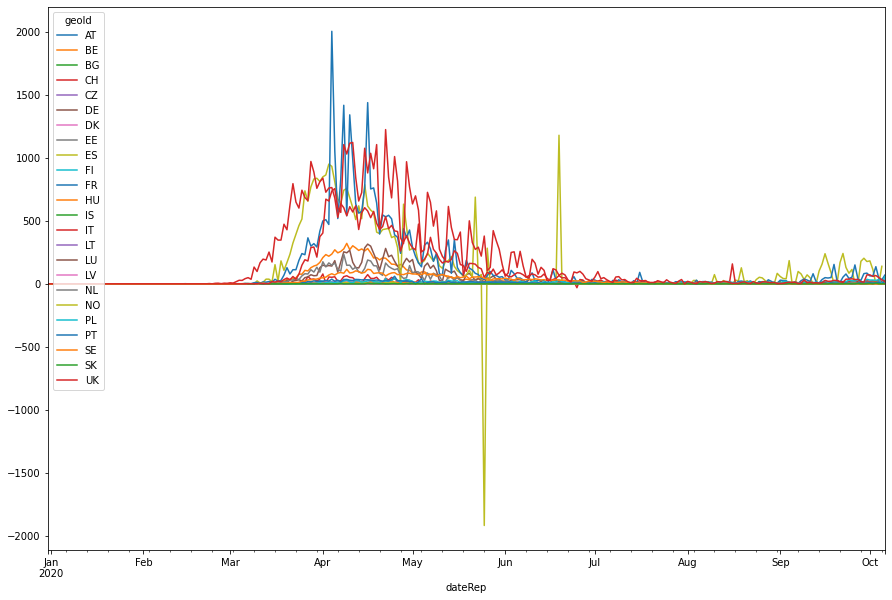

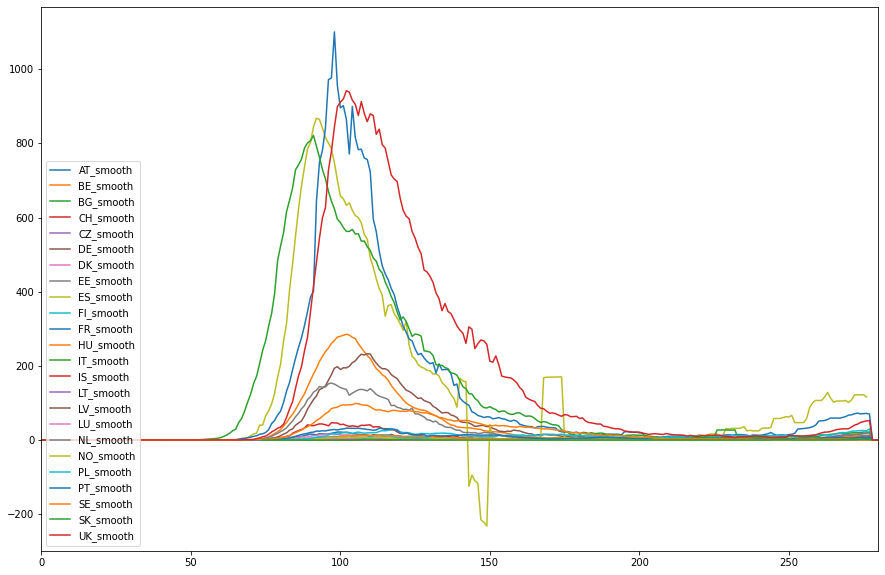

In [5]:
deaths_daily_df = eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["deaths"].unstack()
deaths_daily_smooth_df = pd.DataFrame()
for nation in countries_list:
    deaths_daily_smooth_df[nation + "_smooth"] = moving_avg(deaths_daily_df[nation])
deaths_daily_df.plot(figsize=(15,10))
deaths_daily_smooth_df.plot(figsize=(15,10))
plt.legend(loc="lower left")
plt.savefig("figs/daily_eu_deaths.pdf")
# There is obviously an error in the spanish data here... this error is also present in the JHU data.

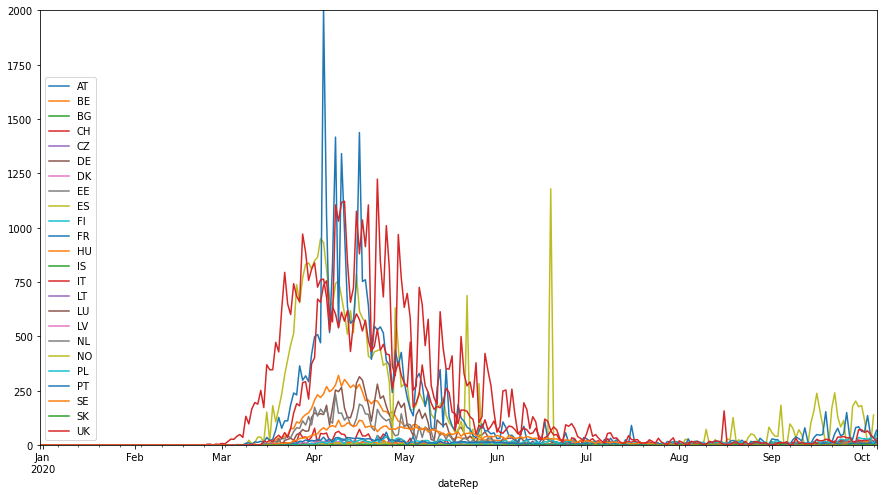

In [6]:
# eu_daily_df[eu_daily_df["geoId"]=="ES"].loc["2020-05":"2020-06"]# and eu_daily_df["deaths"]<0]
# eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["deaths"].unstack().plot(figsize=(15,8))
deaths_daily_df.plot(figsize=(15,8))
plt.ylim(0,2000)
plt.legend(loc="lower left")
plt.savefig("figs/daily_eu_deaths_nice_axis.pdf")

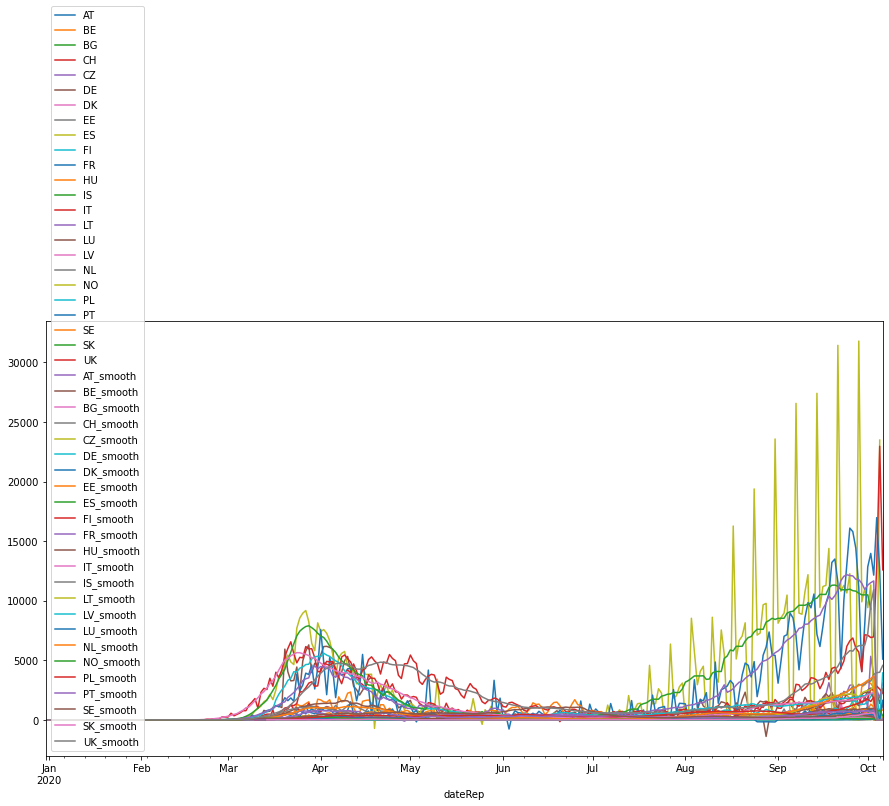

In [7]:
cases_daily_df = eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["cases"].unstack()
for nation in countries_list:
    cases_daily_df[nation + "_smooth"] = moving_avg(cases_daily_df[nation])
cases_daily_df.plot(figsize=(15,8))
# plt.ylim(0,2000)
plt.legend(loc="lower left")
plt.savefig("figs/daily_eu_cases_nice_axis.pdf")
# eu_daily_df

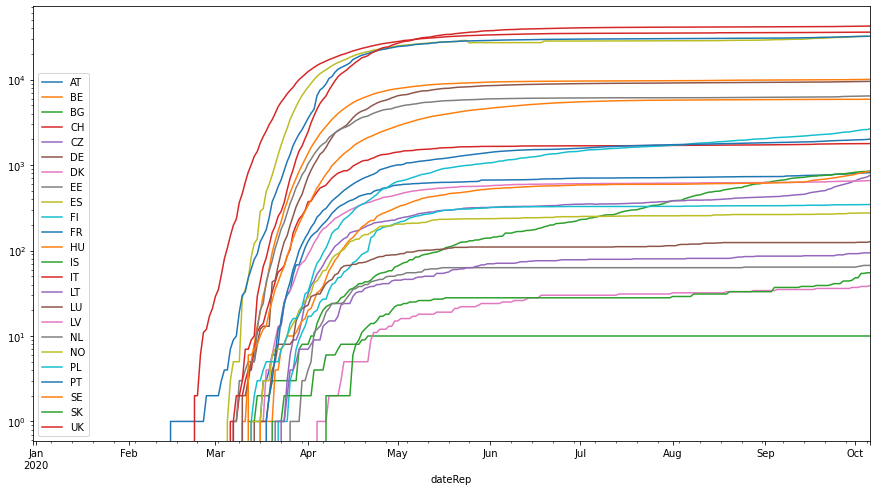

In [8]:
eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["deaths"].unstack().cumsum().plot(figsize=(15,8))
plt.yscale("log")
plt.legend(loc="lower left")
plt.savefig("figs/cumulated_eu_deaths_nice_axis.pdf")

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<AxesSubplot:xlabel='Date'>

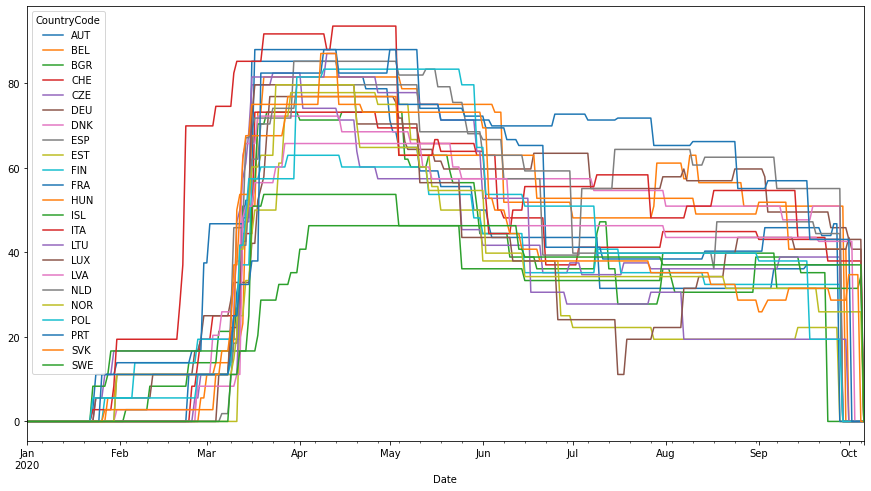

In [9]:
folder_response = "https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/"
file_response = "OxCGRT_latest.csv"
date_parser_response = lambda x: pd.datetime.strptime(str(x), "%Y%m%d")
response_df = pd.read_csv(folder_response + file_response, index_col="Date", parse_dates=["Date"], date_parser=date_parser_response)
response_df
stringency_df = response_df[response_df["CountryCode"].isin(a3_countries_list)].groupby(["Date", "CountryCode"]).sum()["StringencyIndex"].unstack()
stringency_df.plot(figsize=(15,8))